In [1]:
import os

CODIGO_EXPERIMENTO = 'ULMFiT-backward'
TAREFA = 'predict_appeals'
METODO = 'ulmfit'
LOSSFUNC = 'weighted-xentropy'
SENTIDO = 'fwd'
TREINAMENTO = 'gradual'
DATASET = 'JEF-5anos'
EPOCHS = 20
WD = 0.01
NOME_RUNNING = f'01-{CODIGO_EXPERIMENTO}-{METODO}-{TAREFA}-{LOSSFUNC}-{EPOCHS}-{WD}-{DATASET}'
os.environ['WANDB_NOTEBOOK_NAME'] = f'{TAREFA}-{METODO}-{LOSSFUNC}-{EPOCHS}epochs-{TREINAMENTO}-{DATASET}.ipynb'
config = {'epochs': EPOCHS, 'wd': WD, 'dataset': DATASET, 'lossfunc': LOSSFUNC }

import IPython
from fastai import *
from fastai.text import *
from fastai.callbacks import *
from multiprocessing import cpu_count
from fastai.utils.ipython import * 
from fastai.basics import *
import re
import warnings
import wandb
from fastai.metrics import *
from fastai.metrics import CMScores
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from datetime import datetime, timedelta

%matplotlib inline

In [2]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False
random_seed(314, True)

In [3]:
@np_func
def f1micro(inp,targ): return f1_score(targ, np.argmax(inp, axis=-1), average='micro')

@np_func
def f1macro(inp,targ): return f1_score(targ, np.argmax(inp, axis=-1), average='macro')

@np_func
def f1weighted(inp,targ): return f1_score(targ, np.argmax(inp, axis=-1), average='weighted')

@np_func
def bacca(inp,targ): return balanced_accuracy_score(targ, np.argmax(inp, axis=-1), adjusted=True) #0 random 1 perfect

@np_func
def bacc(inp,targ): return balanced_accuracy_score(targ, np.argmax(inp, axis=-1), adjusted=False) # 1 perfect

@np_func
def f1binary(inp,targ): return f1_score(targ, np.argmax(inp, axis=-1), average='binary')

@np_func
def mcc(inp,targ): return matthews_corrcoef(targ, np.argmax(inp, axis=-1))

In [4]:
bs = 64
data_path = Path(os.getcwd())
print(data_path)

/media/jacob/data4/jefs5/paper/code


In [5]:
lang = 'pt'
#name = f'{lang}wiki'
path = data_path
path.mkdir(exist_ok=True, parents=True)
modelsdir = Path('general_portuguese_language_models/ulmfit/')

lm_fns2_fwd = [f'{modelsdir}/{lang}_wt_60k_ulmfit_fwd', f'{modelsdir}/{lang}_wt_vocab_60k_ulmfit_fwd']
lm_fns2_bwd = [f'{modelsdir}/{lang}_wt_60k_ulmfit_bwd', f'{modelsdir}/{lang}_wt_vocab_60k_ulmfit_bwd']

In [6]:
torch.cuda.set_device(1)

In [7]:
import warnings
warnings.filterwarnings('ignore')  

In [8]:
dir_databunch = path / 'databunch_ulmfit'
dir_databunch.mkdir(exist_ok=True, parents=True)

In [9]:
save_path = path / 'saved_models_ulmfit'
save_path.mkdir(exist_ok=True, parents=True)

In [10]:
df_train = pd.read_parquet('../data/train_en.parquet')
df_valid = pd.read_parquet('../data/valid_en.parquet')


In [11]:
df_valid.date_appeal_panel_ruling.head(10)

0    2018-03-26 17:02:04
1    2018-03-26 17:02:45
2    2018-03-26 17:07:16
3    2018-03-26 17:07:16
4    2018-03-26 17:07:16
5    2018-03-26 17:07:16
6    2018-03-26 17:07:16
7    2018-03-26 17:07:16
8    2018-03-26 17:07:16
9    2018-03-26 17:07:16
Name: date_appeal_panel_ruling, dtype: object

In [12]:
print(f'Previous size of training data: {len(df_train)}. Selecting only last 5 years of the training dataset')
df_train.date_appeal_panel_ruling = pd.to_datetime(df_train.date_appeal_panel_ruling, infer_datetime_format=True, yearfirst=True, dayfirst=False)
thresh = df_train.date_appeal_panel_ruling.max() - timedelta(days=365*5)
df_train = df_train[df_train.date_appeal_panel_ruling >= thresh].copy()
print(f'New size of training data: {len(df_train)}')

Previous size of training data: 612961. Selecting only last 5 years of the training dataset
New size of training data: 380526


In [13]:
df_train['is_valid'] = False
df_valid['is_valid'] = True

In [14]:
df = df_train.append(df_valid).copy()

In [15]:
import gc
del(df_train)
del(df_valid)
gc.collect()

0

In [16]:
print(df.shape)


(456868, 37)


In [17]:
df.label.value_counts()

NÃO PROVIMENTO    356907
PROVIMENTO         99961
Name: label, dtype: int64

In [18]:
import joblib


In [19]:
with open(path / 'general_portuguese_language_models/ulmfit/vocab-fwd.joblib', "rb") as f:
    vocab = joblib.load(f)

In [20]:
import gc
gc.collect()

0

In [21]:
%%time
data_clas = (TextList.from_df(df, path, vocab=vocab, cols='preprocessed_full_text_first_instance_court_ruling')
    .split_from_df('is_valid')
    .label_from_df(cols='label')
    .databunch(bs=bs, num_workers=14, backwards=False))

CPU times: user 5min 5s, sys: 8min 5s, total: 13min 11s
Wall time: 17min 12s


In [22]:
%%time
data_clas.save(dir_databunch / f'{CODIGO_EXPERIMENTO}_textlist_{TAREFA}_60k_ulmfit_fwd')

CPU times: user 35.7 s, sys: 34.7 s, total: 1min 10s
Wall time: 1min 34s


## Restarting notebook to release memory
### Rerun cells 1 to 9 before proceeding

In [10]:
%%time
bs = 64
data_clas = load_data(dir_databunch, f'{CODIGO_EXPERIMENTO}_textlist_{TAREFA}_60k_ulmfit_fwd', bs=bs, num_workers=1, backwards=False)

CPU times: user 2min 13s, sys: 22.2 s, total: 2min 35s
Wall time: 2min 56s


In [11]:
data_clas.show_batch()

text,target
xxbos xxup autor : xxup xxunk xxup levi xxup viana xxup de xxup oliveira xxup réu : xxup instituto xxup nacional xxup de xxup seguro xxup social - xxup inss xxup sentença xxmaj trata - se de ação de rito sumaríssimo na qual se postula a concessão de benefício de aposentadoria especial ou por tempo de contribuição e o pagamento de diferenças devidas a esse título . xxmaj dispensado relatório,NÃO PROVIMENTO
xxbos xxup previdenciário . xxup aposentadoria xxup por xxup tempo xxup de xxup serviço / xxup contribuição . xxup ii . xxup conversão xxup de xxup tempo xxup de xxup serviço xxup especial xxup em xxup comum . xxup vínculos xxup como xxup forneiro e xxup pintor . xxup exigência xxup de xxup comprovação xxup da xxup habitualidade e xxup permanência xxup do xxup serviço . xxup iii . xxup,PROVIMENTO
"xxbos xxup autor ( xxup xxunk xxup costa xxup da xxup silva xxup réu : xxup inss - xxmaj instituto xxmaj nacional do xxmaj seguro xxmaj social xxup sentença xxmaj trata - se de ação de rito sumaríssimo , na qual se postula a concessão de benefício de aposentadoria especial , subsidiariamente , aposentadoria por tempo de contribuição , bem como o pagamento de diferenças retroativas devidas a esse título",PROVIMENTO
"xxbos xxup autor : xxup cícero xxup faustino xxup de xxup oliveira xxup réu : xxup inss – xxup instituto xxup nacional xxup do xxup seguro xxup social xxup sentença xxmaj trata - se de ação ajuizada contra xxup inss – xxmaj instituto xxmaj nacional do xxmaj seguro xxmaj social , na qual postula a concessão do benefício de aposentadoria por tempo de contribuição com conversão de tempo especial em",NÃO PROVIMENTO
"xxbos xxup autor ( xxup xxunk xxup valério xxup de xxup lima xxup réu : xxup inss - xxmaj instituto xxmaj nacional do xxmaj seguro xxmaj social xxup sentença xxmaj trata - se de ação de rito sumaríssimo , na qual se postula a concessão de benefício de aposentadoria por tempo de contribuição , bem como o pagamento de diferenças retroativas devidas a esse título . a título de esclarecimento",NÃO PROVIMENTO


In [12]:
all_metrics = [accuracy, error_rate, mcc]
learn_c = text_classifier_learner(data_clas, AWD_LSTM, pretrained=False, drop_mult=0.3, 
                                  metrics=all_metrics, lin_ftrs=[100]).to_fp16()

In [13]:
learn_c.load_encoder(path / 'legal_portuguese_language_models/05-2020_fine_tuned_enc_lm_sentencas_60k_ulmfit_fwd');

In [14]:
learn_c.loss_func

FlattenedLoss of CrossEntropyLoss()

## Get weights to penalize loss function of the majority class

In [15]:
num_trn = len(data_clas.train_ds.x)
num_val = len(data_clas.valid_ds.x)
num_trn, num_val, num_trn+num_val

(380526, 76342, 456868)

In [16]:
trn_LabelCounts = np.unique(data_clas.train_ds.y.items, return_counts=True)[1]
val_LabelCounts = np.unique(data_clas.valid_ds.y.items, return_counts=True)[1]
trn_LabelCounts, val_LabelCounts

(array([297447,  83079]), array([59460, 16882]))

In [17]:
trn_weights = [1 - count/num_trn for count in trn_LabelCounts]
val_weights = [1 - count/num_val for count in val_LabelCounts]
trn_weights, val_weights

([0.2183267372006118, 0.7816732627993882],
 [0.22113646485551863, 0.7788635351444815])

In [18]:
loss_weights = torch.FloatTensor(trn_weights).cuda()

In [19]:
learn_c.loss_func = CrossEntropyFlat(weight=loss_weights )

In [20]:
learn_c.loss_func

FlattenedLoss of CrossEntropyLoss()

In [21]:
learn_c.loss_func.weight

tensor([0.2183, 0.7817], device='cuda:1')

epoch,train_loss,valid_loss,accuracy,error_rate,mcc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-06
Min loss divided by 10: 6.92E-03


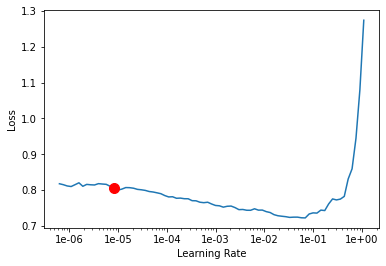

In [22]:
with gpu_mem_restore_ctx():
    learn_c.lr_find()
learn_c.recorder.plot(suggestion=True)

In [23]:
lr = 1e-3
print(lr, bs)
wd = WD
print(wd)

0.001 64
0.01


In [24]:
nome = f'tmp/{CODIGO_EXPERIMENTO}-{METODO}-{TAREFA}-{LOSSFUNC}-{EPOCHS}-{WD}-{lr}-{DATASET}-fwd'


In [25]:
callbacks=[SaveModelCallback(learn_c, monitor='mcc', name=nome, mode='max')]
print(nome)

tmp/ULMFiT-backward-ulmfit-predict_appeals-weighted-xentropy-20-0.01-0.001-JEF-5anos-fwd


In [26]:
learn_c.freeze();


In [27]:
with gpu_mem_restore_ctx():    
    learn_c.fit_one_cycle(int(EPOCHS*0.2), lr, wd=wd,
                          moms=(0.8,0.7),
                          callbacks=callbacks)

epoch,train_loss,valid_loss,accuracy,error_rate,mcc,time
0,0.580981,0.644670,0.721215,0.278785,0.229738,26:52
1,0.552971,0.622674,0.723180,0.276820,0.260207,31:01
2,0.553172,0.622032,0.740824,0.259176,0.260678,30:32
3,0.545132,0.594874,0.735663,0.264337,0.293699,31:00


Better model found at epoch 0 with mcc value: 0.2297377979455668.
Better model found at epoch 1 with mcc value: 0.26020680708058613.
Better model found at epoch 2 with mcc value: 0.26067831068792424.
Better model found at epoch 3 with mcc value: 0.29369941550921314.


In [28]:
n = 1
learn_c.load(nome);
learn_c.save(f'{nome}_{n}')


In [29]:
learn_c.freeze_to(-2)

with gpu_mem_restore_ctx():
    learn_c.fit_one_cycle(int(EPOCHS*0.2), slice(lr/(2.6**4),lr), wd=wd,
                          moms=(0.8,0.7),
                          callbacks=callbacks)

epoch,train_loss,valid_loss,accuracy,error_rate,mcc,time
0,0.546600,0.581770,0.705536,0.294464,0.288511,34:56
1,0.540216,0.602462,0.723429,0.276571,0.291249,32:26
2,0.509804,0.582574,0.734537,0.265463,0.308792,35:54
3,0.496066,0.608473,0.747740,0.252260,0.306895,33:24


Better model found at epoch 0 with mcc value: 0.28851117816130345.
Better model found at epoch 1 with mcc value: 0.2912494536965795.
Better model found at epoch 2 with mcc value: 0.3087921585692786.


In [30]:
n = 2
learn_c.load(nome);
learn_c.save(f'{nome}_{n}')


In [31]:
learn_c.freeze_to(-3)

with gpu_mem_restore_ctx():
    learn_c.fit_one_cycle(int(EPOCHS*0.2), slice(lr/2/(2.6**4),lr/2), wd=wd,
                          moms=(0.8,0.7),
                          callbacks=callbacks)

epoch,train_loss,valid_loss,accuracy,error_rate,mcc,time
0,0.512869,0.595486,0.713133,0.286867,0.297132,43:34
1,0.497745,0.578586,0.717914,0.282086,0.315494,46:19
2,0.475712,0.591799,0.726075,0.273925,0.312891,41:56
3,0.457767,0.600505,0.727751,0.272249,0.312518,39:10


Better model found at epoch 0 with mcc value: 0.29713219808214847.
Better model found at epoch 1 with mcc value: 0.31549360165663265.


In [32]:
n = 3
learn_c.load(nome);
learn_c.save(f'{nome}_{n}')


In [33]:
with gpu_mem_restore_ctx():
    learn_c.unfreeze()
    learn_c.fit_one_cycle(int(EPOCHS*0.4), slice(lr/10/(2.6**4),lr/10), wd=wd,
                          moms=(0.8,0.7),
                          callbacks=callbacks)


epoch,train_loss,valid_loss,accuracy,error_rate,mcc,time
0,0.482845,0.574646,0.721713,0.278287,0.321743,48:48
1,0.466427,0.577733,0.710592,0.289408,0.319242,57:56
2,0.476263,0.587351,0.718425,0.281575,0.315727,57:24
3,0.470129,0.602873,0.734340,0.265660,0.314315,50:22
4,0.457088,0.586732,0.713670,0.286330,0.319831,52:39
5,0.454822,0.590853,0.717076,0.282924,0.318785,47:48
6,0.457527,0.596995,0.720102,0.279898,0.318659,51:24
7,0.451514,0.611825,0.726965,0.273035,0.314625,49:56


Better model found at epoch 0 with mcc value: 0.32174331355165686.


In [34]:
n = 4
learn_c.load(nome);
learn_c.save(f'{nome}_{n}')


In [35]:
learn_c.load(f'{nome}_{4}');


In [36]:
from sklearn.metrics import matthews_corrcoef

In [38]:
preds, y= learn_c.get_preds(with_loss=False, ordered=True)
predictions = np.argmax(preds, axis = 1)

print(f'BAC:          {balanced_accuracy_score(predictions, y):.4f}')
print(f'F1-WEIGHTED:  {f1_score(predictions, y, average="weighted"):.4f}')
print(f'F1-MICRO:     {f1_score(predictions, y, average="micro"):.4f}')
print(f'F1-MACRO:     {f1_score(predictions, y, average="macro"):.4f}')
print(f'F1-BINARY:    {f1_score(predictions, y, average="binary"):.4f}')
print(f'BAC ADJUSTED: {balanced_accuracy_score(predictions, y, adjusted=True):.4f}')
print(f'MCC:        {matthews_corrcoef(predictions, y):.4f}')

BAC:          0.6441
F1-WEIGHTED:  0.7045
F1-MICRO:     0.7217
F1-MACRO:     0.6521
F1-BINARY:    0.4965
BAC ADJUSTED: 0.2882
MCC:        0.3270


In [39]:
from sklearn.metrics import classification_report , confusion_matrix
print('\n\n', classification_report(predictions, y))
print('\n\n', confusion_matrix(predictions, y))



               precision    recall  f1-score   support

           0       0.75      0.87      0.81     51031
           1       0.62      0.41      0.50     25311

    accuracy                           0.72     76342
   macro avg       0.69      0.64      0.65     76342
weighted avg       0.71      0.72      0.70     76342



 [[44623  6408]
 [14837 10474]]


In [41]:
learn_c.model._forward_hooks = OrderedDict()

In [42]:
learn_c.metric = list()

In [43]:
learn_c.to_fp32().export(save_path / f'ulmfit_forward_exported')
# experiment.stop()